In [29]:
# imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [30]:
# Load the dataset
dataset = pd.read_csv('../data/dataset.csv')
print(dataset)

       schoolid  Z         Y  S3  C1  C2  C3  XC        X1        X2  \
0            76  1  0.081602   6   4   2   1   4  0.334544  0.648586   
1            76  1 -0.385869   4  12   2   1   4  0.334544  0.648586   
2            76  1  0.398184   6   4   2   0   4  0.334544  0.648586   
3            76  1 -0.175037   6   4   2   0   4  0.334544  0.648586   
4            76  1  0.884583   6   4   1   0   4  0.334544  0.648586   
...         ... ..       ...  ..  ..  ..  ..  ..       ...       ...   
10386         1  0  0.423366   7   4   2   1   3  1.185986 -1.129889   
10387         1  0 -0.197092   7   4   2   1   3  1.185986 -1.129889   
10388         1  0  0.141698   2  15   1   1   3  1.185986 -1.129889   
10389         1  0 -0.351565   5   4   1   1   3  1.185986 -1.129889   
10390         1  0  0.211240   5   1   2   1   3  1.185986 -1.129889   

             X3        X4        X5  
0     -1.310927  0.224077 -0.426757  
1     -1.310927  0.224077 -0.426757  
2     -1.310927  0.22

In [31]:
# Define covariates, treatment, and outcome
covariate_cols = ['S3', 'C1', 'C2', 'C3', 'XC', 'X1', 'X2', 'X3', 'X4', 'X5']
treatment_col = 'Z'
outcome_col = 'Y'

In [32]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)

In [33]:
# Standardize the covariates
scaler = StandardScaler()
train_data[covariate_cols] = scaler.fit_transform(train_data[covariate_cols])
test_data[covariate_cols] = scaler.transform(test_data[covariate_cols])


<ipython-input-33-ffd184b08ad1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[covariate_cols] = scaler.fit_transform(train_data[covariate_cols])
C:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-33-ffd184b08ad1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [34]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

def s_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an S-learner model to estimate CATE.
    """
    # Create the covariates matrix, treatment, and outcome vectors
    X = data[covariate_cols + [treatment_col]]
    y = data[outcome_col]

    # Fit the model
    model.fit(X, y)

    return model

# Train S-learner with different models
s_learner_rf = s_learner(train_data, treatment_col, outcome_col, covariate_cols, RandomForestRegressor(n_estimators=100, random_state=42))
s_learner_gb = s_learner(train_data, treatment_col, outcome_col, covariate_cols, GradientBoostingRegressor(n_estimators=100, random_state=42))
s_learner_nn = s_learner(train_data, treatment_col, outcome_col, covariate_cols, MLPRegressor(random_state=42, max_iter=500))



In [35]:
def t_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train a T-learner model to estimate CATE.
    """
    # Split data into treatment and control groups
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]

    X_treated = treated[covariate_cols]
    y_treated = treated[outcome_col]

    X_control = control[covariate_cols]
    y_control = control[outcome_col]

    # Fit the models
    model_treated = model.fit(X_treated, y_treated)
    model_control = model.fit(X_control, y_control)

    return model_treated, model_control

# Train T-learner with different models
t_learner_rf = t_learner(train_data, treatment_col, outcome_col, covariate_cols, RandomForestRegressor(n_estimators=100, random_state=42))
t_learner_gb = t_learner(train_data, treatment_col, outcome_col, covariate_cols, GradientBoostingRegressor(n_estimators=100, random_state=42))
t_learner_nn = t_learner(train_data, treatment_col, outcome_col, covariate_cols, MLPRegressor(random_state=42, max_iter=500))

In [43]:
def x_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an X-learner model to estimate CATE.
    """
    # Split data into treatment and control groups
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]

    X_treated = treated[covariate_cols]
    y_treated = treated[outcome_col]

    X_control = control[covariate_cols]
    y_control = control[outcome_col]

    # Step 1: Train T-learners
    model_treated = model.fit(X_treated, y_treated)
    model_control = model.fit(X_control, y_control)

    # Step 2: Predict outcomes
    treated_outcome = model_control.predict(X_treated)
    control_outcome = model_treated.predict(X_control)

    # Step 3: Compute imputed treatment effects
    treatment_effect_treated = y_treated - treated_outcome
    treatment_effect_control = control_outcome - y_control

    # Step 4: Train second-stage models
    model_treatment_effect_treated = model.fit(X_treated, treatment_effect_treated)
    model_treatment_effect_control = model.fit(X_control, treatment_effect_control)

    return model_treatment_effect_treated, model_treatment_effect_control

# Train X-learner with different models
x_learner_rf = x_learner(train_data, treatment_col, outcome_col, covariate_cols, RandomForestRegressor(n_estimators=100, random_state=42))
x_learner_gb = x_learner(train_data, treatment_col, outcome_col, covariate_cols, GradientBoostingRegressor(n_estimators=100, random_state=42))
x_learner_nn = x_learner(train_data, treatment_col, outcome_col, covariate_cols, MLPRegressor(random_state=42, max_iter=500))

In [52]:
import numpy as np
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

def r_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an R-learner model to estimate CATE.
    """
    # Create the covariates matrix and the outcome vector
    X = data[covariate_cols]
    T = data[treatment_col]
    y = data[outcome_col]

    # Step 1: Fit a model to predict the outcome using covariates
    y_model = model
    y_model.fit(X, y)

    # Step 2: Fit a model to predict the treatment using covariates
    t_model = model
    t_model.fit(X, T)

    # Compute residuals
    y_residual = y - y_model.predict(X)
    t_residual = T - t_model.predict(X)

    # Clip t_residual to avoid extremely small values
    t_residual_clipped = t_residual.clip(lower=0.01)

    # Normalize residuals
    y_residual = (y_residual - np.mean(y_residual)) / np.std(y_residual)
    t_residual = (t_residual_clipped - np.mean(t_residual_clipped)) / np.std(t_residual_clipped)

    # Print diagnostic information
    print("Y residuals:")
    print(y_residual.describe())
    print("T residuals:")
    print(t_residual.describe())

    # Add a regularization term to avoid division by very small values
    epsilon = 1e-3 * np.std(t_residual)
    t_residual_regularized = t_residual + epsilon

    # Print diagnostic information
    print("Regularized T residuals:")
    print(t_residual_regularized.describe())

    # Step 3: Fit a Ridge Regression model on the residuals to estimate the treatment effect
    tau_model = Ridge(alpha=1.0)  # Regularization strength; must be a positive float
    tau_model.fit(X, y_residual / t_residual_regularized)

    return tau_model, y_model, t_model, y_residual, t_residual


# Train R-learner with different models
r_learner_rf = r_learner(train_data, treatment_col, outcome_col, covariate_cols, RandomForestRegressor(n_estimators=100, random_state=42))
r_learner_gb = r_learner(train_data, treatment_col, outcome_col, covariate_cols, GradientBoostingRegressor(n_estimators=100, random_state=42))
r_learner_nn = r_learner(train_data, treatment_col, outcome_col, covariate_cols, MLPRegressor(random_state=42, max_iter=500))

Y residuals:
count    7.273000e+03
mean    -3.112395e-15
std      1.000069e+00
min     -3.413062e+00
25%     -6.931496e-01
50%     -1.853035e-02
75%      6.771583e-01
max      3.371207e+00
Name: Y, dtype: float64
T residuals:
count    7.273000e+03
mean     2.168237e-14
std      1.000069e+00
min     -5.982854e-01
25%     -5.982854e-01
50%     -5.982854e-01
75%      4.714564e-01
max      3.252409e+00
Name: Z, dtype: float64
Regularized T residuals:
count    7273.000000
mean        0.001000
std         1.000069
min        -0.597285
25%        -0.597285
50%        -0.597285
75%         0.472456
max         3.253409
Name: Z, dtype: float64
Y residuals:
count    7.273000e+03
mean    -5.104003e-16
std      1.000069e+00
min     -3.122033e+00
25%     -7.004194e-01
50%     -4.340920e-02
75%      6.776332e-01
max      3.754026e+00
Name: Y, dtype: float64
T residuals:
count    7.273000e+03
mean     1.814013e-14
std      1.000069e+00
min     -6.860917e-01
25%     -6.860917e-01
50%     -6.860917e-01

In [53]:
from sklearn.metrics import mean_squared_error

def evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, model, meta_learner):
    """
    Evaluate the performance of a meta-learner.
    """
    X_test = test_data[covariate_cols + [treatment_col]]
    y_test = test_data[outcome_col]

    if meta_learner == 's':
        predictions = model.predict(X_test)
    elif meta_learner == 't':
        treated, control = model
        predictions_treated = treated.predict(test_data[test_data[treatment_col] == 1][covariate_cols])
        predictions_control = control.predict(test_data[test_data[treatment_col] == 0][covariate_cols])
        predictions = pd.concat([pd.Series(predictions_treated), pd.Series(predictions_control)], ignore_index=True)
    elif meta_learner == 'x':
        treated, control = model
        predictions_treated = treated.predict(test_data[test_data[treatment_col] == 1][covariate_cols])
        predictions_control = control.predict(test_data[test_data[treatment_col] == 0][covariate_cols])
        predictions = pd.concat([pd.Series(predictions_treated), pd.Series(predictions_control)], ignore_index=True)
    elif meta_learner == 'r':
        tau_model, _, _, _, _ = model
        predictions = tau_model.predict(test_data[covariate_cols])
        # Print diagnostic information
        print("Predictions:")
        print(pd.Series(predictions).describe())

    mse = mean_squared_error(y_test, predictions)
    return mse

# Evaluate S-learner
mse_s_rf = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, s_learner_rf, 's')
mse_s_gb = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, s_learner_gb, 's')
mse_s_nn = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, s_learner_nn, 's')

# Evaluate T-learner
mse_t_rf = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, t_learner_rf, 't')
mse_t_gb = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, t_learner_gb, 't')
mse_t_nn = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, t_learner_nn, 't')

# Evaluate X-learner
mse_x_rf = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, x_learner_rf, 'x')
mse_x_gb = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, x_learner_gb, 'x')
mse_x_nn = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, x_learner_nn, 'x')

# Evaluate R-learner
mse_r_rf = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, r_learner_rf, 'r')
mse_r_gb = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, r_learner_gb, 'r')
mse_r_nn = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, r_learner_nn, 'r')

# Print results
print(f'S-learner (RandomForest): {mse_s_rf}')
print(f'S-learner (GradientBoosting): {mse_s_gb}')
print(f'S-learner (NeuralNetwork): {mse_s_nn}')
print(f'T-learner (RandomForest): {mse_t_rf}')
print(f'T-learner (GradientBoosting): {mse_t_gb}')
print(f'T-learner (NeuralNetwork): {mse_t_nn}')
print(f'X-learner (RandomForest): {mse_x_rf}')
print(f'X-learner (GradientBoosting): {mse_x_gb}')
print(f'X-learner (NeuralNetwork): {mse_x_nn}')
print(f'R-learner (RandomForest): {mse_r_rf}')
print(f'R-learner (GradientBoosting): {mse_r_gb}')
print(f'R-learner (NeuralNetwork): {mse_r_nn}')

Predictions:
count    3118.000000
mean       -0.167160
std         0.410451
min        -1.523592
25%        -0.456733
50%        -0.090821
75%         0.128952
max         0.938877
dtype: float64
Predictions:
count    3118.000000
mean        0.416813
std         0.962044
min        -2.366824
25%        -0.228671
50%         0.376987
75%         0.999536
max         3.987035
dtype: float64
Predictions:
count    3118.000000
mean        0.199334
std         0.279071
min        -0.542978
25%         0.012239
50%         0.181903
75%         0.352010
max         1.329004
dtype: float64
S-learner (RandomForest): 0.32986833479089345
S-learner (GradientBoosting): 0.2691898556942669
S-learner (NeuralNetwork): 0.2917221061142651
T-learner (RandomForest): 0.6137174948393895
T-learner (GradientBoosting): 0.5435492670494957
T-learner (NeuralNetwork): 0.5595374191831007
X-learner (RandomForest): 0.43925880131372813
X-learner (GradientBoosting): 0.4363340119121809
X-learner (NeuralNetwork): 0.4378472

In [54]:
import pandas as pd

# Aggregate the MSE values into a DataFrame
mse_data = {
    'Meta-Learner': ['S-Learner', 'S-Learner', 'S-Learner', 'T-Learner', 'T-Learner', 'T-Learner',
                     'X-Learner', 'X-Learner', 'X-Learner', 'R-Learner', 'R-Learner', 'R-Learner'],
    'Model': ['RandomForest', 'GradientBoosting', 'NeuralNetwork', 'RandomForest', 'GradientBoosting', 'NeuralNetwork',
              'RandomForest', 'GradientBoosting', 'NeuralNetwork', 'RandomForest', 'GradientBoosting', 'NeuralNetwork'],
    'MSE': [mse_s_rf, mse_s_gb, mse_s_nn, mse_t_rf, mse_t_gb, mse_t_nn, mse_x_rf, mse_x_gb, mse_x_nn, mse_r_rf, mse_r_gb, mse_r_nn]
}

mse_df = pd.DataFrame(mse_data)

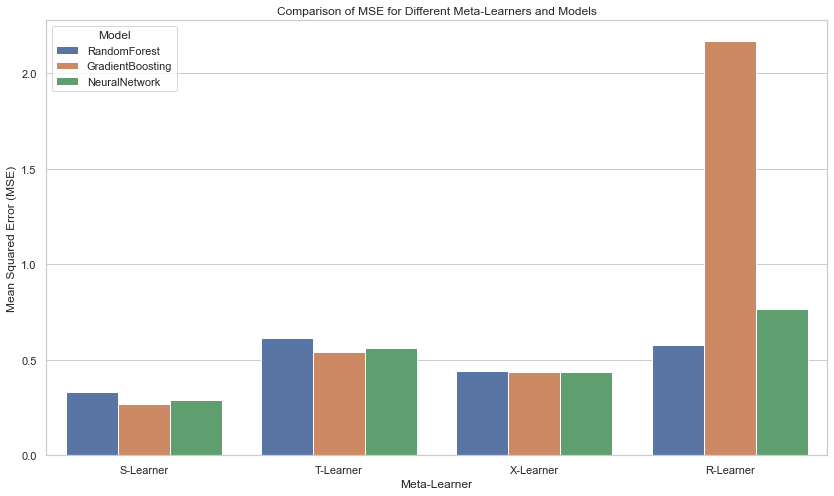

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Meta-Learner', y='MSE', hue='Model', data=mse_df)
plt.title('Comparison of MSE for Different Meta-Learners and Models')
plt.xlabel('Meta-Learner')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(title='Model')
plt.show()

In [60]:
from IPython.display import Markdown, display

# Define the markdown content
conclusion = """
### Interpretation of Results

#### S-Learner:
- GradientBoosting has the lowest MSE (0.269), followed by NeuralNetwork (0.292) and RandomForest (0.330).

#### T-Learner:
- GradientBoosting also performs best for the T-Learner (0.544), followed by NeuralNetwork (0.560) and RandomForest (0.614).

#### X-Learner:
- All models have very similar MSE values (around 0.436 to 0.439).

#### R-Learner:
- RandomForest shows a significant improvement with an MSE of 0.576.
- NeuralNetwork also performs reasonably well with an MSE of 0.765.
- GradientBoosting has a higher MSE of 2.169, indicating it may not be as suitable for the R-learner in this context.
"""

# Display the markdown
display(Markdown(conclusion))




### Interpretation of Results

#### S-Learner:
- GradientBoosting has the lowest MSE (0.269), followed by NeuralNetwork (0.292) and RandomForest (0.330).

#### T-Learner:
- GradientBoosting also performs best for the T-Learner (0.544), followed by NeuralNetwork (0.560) and RandomForest (0.614).

#### X-Learner:
- All models have very similar MSE values (around 0.436 to 0.439).

#### R-Learner:
- RandomForest shows a significant improvement with an MSE of 0.576.
- NeuralNetwork also performs reasonably well with an MSE of 0.765.
- GradientBoosting has a higher MSE of 2.169, indicating it may not be as suitable for the R-learner in this context.
